# Jupyter notebook with ROS
### Tachadol Suthisomboon

In [18]:
import jupyros as jr
import rospy
from jupyros import ros3d
from geometry_msgs.msg import Twist
import os
import ipywidgets as widgets
from IPython.core.display import display, HTML, Markdown, clear_output
from std_srvs.srv import *
from sensor_msgs.msg import LaserScan
import time
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import math
import numpy as np

import tf
from nav_msgs.msg import Odometry
from tf.transformations import quaternion_matrix

rospy.init_node('main_rt3_jupyrter')


/tmp/ipykernel_18611/2594633932.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown, clear_output
/tmp/ipykernel_18611/2594633932.py:7: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown, clear_output


In [20]:
# @hidden
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('.cm-comment:contains(@hidden)').closest('div.input').hide();
 } else {
 $('.cm-comment:contains(@hidden)').closest('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [5]:
# @hidden

from jupyros import ros3d
import os
v = ros3d.Viewer()
rc = ros3d.ROSConnection(url="ws://localhost:9090")
tf_client = ros3d.TFClient(ros=rc, fixed_frame='map')
laser_view = ros3d.LaserScan(topic="/scan", ros=rc, tf_client=tf_client)
map_view = ros3d.OccupancyGrid(topic="/map", ros=rc, tf_client=tf_client)
path = ros3d.Path(topic="/move_base/NavfnROS/plan", ros=rc,
tf_client=tf_client)
urdf = ros3d.URDFModel(ros=rc, tf_client=tf_client,
path=os.environ.get('JUPYROS_ASSETS_URL', 'http://localhost:3000'))
g = ros3d.GridModel()
v.objects = [g, laser_view, map_view, path, urdf]
v

Viewer(objects=[GridModel(), LaserScan(ros=ROSConnection(url='ws://localhost:9090'), tf_client=TFClient(fixed_…

In [15]:
# @hidden
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('.cm-comment:contains(@hidden)').closest('div.input').hide();
 } else {
 $('.cm-comment:contains(@hidden)').closest('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

import rospy
from std_srvs.srv import *
from geometry_msgs.msg import Twist
from sensor_msgs.msg import LaserScan
import time
import ipywidgets as widgets
from ipywidgets import Button, HBox, VBox
from IPython.core.display import display, HTML, Markdown, clear_output

#Parameters
obstacle_detection_range = 1
"""Int: varible for defining the range of detection for assisted control.
"""

srv_activate_goto_ = None
"""Service: Service hadler between ui_rt3 -> goto_rt3
"""
mode_ = 0
"""Int: mode of the robot
"""
sub_laser_ = None
"""Subscriber: Subscriber handeler for lase scanner
"""
sub_cmd_vel_kb_ = None
"""Subscriber: Subscriber handeler for teleop_twist_keyboard
"""
pub_cmd_vel_ =None
"""Publisher: Publisher handeler for conveying the information to simulation
"""
able_to_move_ = [0, 0, 0, 0, 0] #% array including right fringht front fleft and left
"""Int: (5 x 1 array): Consists of status of each zone (left, front-left, front, front-right, right)
"""

vel_msg = Twist()
"""Twist: Information of robot
"""
TwistMsg = Twist()

def check_obstruc(regions, key, index):
    """
    Function for check obstructcal by using laser scanner and assign in to occupancy list.
    Args:
    regions(dictionary): dictionary of laser scanner in each direction
    key(string): key for regions
    index(int): indexing of occupancy list
    """
    global able_to_move_

    if regions[key] > obstacle_detection_range :
        able_to_move_[index] = 1
    else :
        able_to_move_[index] = 0

def clbk_laser(msg): #this part of function was obtianed from obstacle_avoidance.py
    """
    Callback function for laser scanner. this function will be called when the msg from laser scanner has been published
    Args:
    msg(int array): data from lase scanner
    """
    global vel_msg
    regions = {
        'right':  min(min(msg.ranges[0:143]), 10),
        'fright': min(min(msg.ranges[144:287]), 10),
        'front':  min(min(msg.ranges[288:431]), 10),
        'fleft':  min(min(msg.ranges[432:575]), 10),
        'left':   min(min(msg.ranges[576:719]), 10),
    }
    check_obstruc(regions, 'right', 0)
    check_obstruc(regions, 'fright', 1)
    check_obstruc(regions, 'front', 2)
    check_obstruc(regions, 'fleft', 3)
    check_obstruc(regions, 'left', 4)

    ## If there is any obstacle in the direction that robot heading to it's going to stop
    if able_to_move_[0] == 0 and vel_msg.angular.z < 0 :
        vel_msg.angular.z = 0
    if able_to_move_[1] == 0 and vel_msg.linear.x > 0 and vel_msg.angular.z < 0 :
        vel_msg.linear.x = 0
        vel_msg.angular.z = 0
    if able_to_move_[2] == 0 and vel_msg.linear.x > 0 :
        vel_msg.linear.x = 0
    if able_to_move_[3] == 0 and vel_msg.linear.x > 0  and vel_msg.angular.z > 0:
        vel_msg.linear.x = 0
        vel_msg.angular.z = 0
    if able_to_move_[4] == 0 and vel_msg.angular.z > 0:
        vel_msg.angular.z = 0
    pub_cmd_vel_.publish(vel_msg)


def clbk_twist_kb(msg):
    """
    Callback function for teleop_twist_keyboard. this function will be called when the twist from teleop_twist_keyboard has been published
    Args:
    msg(twist): data from lase scanner
    """
    global  mode_
    global sub_laser_, sub_cmd_vel_kb_, vel_msg_, pub_cmd_vel_, vel_msg
    ##print("recied")
    ##print ("Mode of robot: " + str(mode_))

    if mode_ == 2:
        #rospy.loginfo("Received a /cmd_vel message!")
        #rospy.loginfo("Linear Components: [%f, %f, %f]"%(msg.linear.x, msg.linear.y, msg.linear.z))
        #rospy.loginfo("Angular Components: [%f, %f, %f]"%(msg.angular.x, msg.angular.y, msg.angular.z))
        vel_msg.linear.x = msg.linear.x
        vel_msg.linear.y = msg.linear.y
        vel_msg.linear.z = msg.linear.z
        vel_msg.angular.x = msg.angular.x
        vel_msg.angular.y = msg.angular.y
        vel_msg.angular.z = msg.angular.z
        pub_cmd_vel_.publish(vel_msg)
    elif mode_ == 3:
        vel_msg.linear.x = msg.linear.x
        vel_msg.linear.y = msg.linear.y
        vel_msg.linear.z = msg.linear.z
        vel_msg.angular.x = msg.angular.x
        vel_msg.angular.y = msg.angular.y
        vel_msg.angular.z = msg.angular.z

        ##check before publish in order to avoid the issue that user hold on the direction that was obstracted
        if able_to_move_[0] == 0 and msg.angular.z < 0:
            vel_msg.angular.z = 0
        if able_to_move_[1] == 0 and msg.angular.z < 0 and msg.linear.x > 0:
            vel_msg.linear.x = 0
            vel_msg.angular.z = 0
        if able_to_move_[2] == 0 and msg.linear.x > 0 :
            vel_msg.linear.x = 0
        if able_to_move_[3] == 0 and msg.linear.x > 0 and msg.angular.z > 0:
            vel_msg.linear.x = 0
            vel_msg.angular.z = 0
        if able_to_move_[4] == 0 and msg.angular.z > 0:
            vel_msg.angular.z = 0
        pub_cmd_vel_.publish(vel_msg)

rospy.set_param('/reachedAndNot', [0, 0])
        
sub_laser_ = rospy.Subscriber('/scan', LaserScan, clbk_laser)
sub_laser_.unregister()
sub_cmd_vel_kb_ = rospy.Subscriber("/cmd_vel_kb", Twist, clbk_twist_kb)
pub_cmd_vel_ = rospy.Publisher('/cmd_vel', Twist, queue_size=1)

srv_activate_goto_ = rospy.ServiceProxy('/activate_goto', SetBool)

##========================================
enter1 = widgets.Button(description='OK')
enter2 = widgets.Button(description='Activate')
enter3 = widgets.Button(description='Activate')
cancel = widgets.Button(description='Cancel')

FrontLeft = widgets.Button(description='FL')
Front = widgets.Button(description='F')
FrontRight = widgets.Button(description='FR')

Left = widgets.Button(description='L')
Right = widgets.Button(description='R')

Stop = widgets.Button(description='Stop')
BackLeft = widgets.Button(description='BL')
Back = widgets.Button(description='B')
BackRight = widgets.Button(description='BR')



Control = rospy.Publisher('cmd_vel_kb', Twist, queue_size = 1)



out = widgets.Output()
def enter_button1(_):
    global mode_
    mode_ = 1
    rospy.set_param('des_pos_x',int(x_pos.value))
    rospy.set_param('des_pos_y',int(y_pos.value))
    resp = srv_activate_goto_(True)
    with out:
        clear_output()
        print("Mode:", mode_)

def enter_button2(_):
    global mode_
    mode_ = 2
    sub_laser_.unregister()
    resp = srv_activate_goto_(False)
    with out:
        clear_output()
        print("Mode:", mode_)

def enter_button3(_):
    global mode_
    mode_ = 3
    sub_laser_ = rospy.Subscriber('/scan', LaserScan, clbk_laser)
    resp = srv_activate_goto_(False)
    with out:
        clear_output()
        print("Mode:", mode_)
    
def cancel_button(_):
      # "linking function with output"
    resp = srv_activate_goto_(False)

def FrontLeft_clbk(_):
    twist_msg = Twist()
    twist_msg.linear.x = 0.5
    twist_msg.linear.y = 0
    twist_msg.linear.z = 0
    twist_msg.angular.x = 0
    twist_msg.angular.y = 0
    twist_msg.angular.z = 1
    Control.publish(twist_msg)

def Front_clbk(_):
    twist_msg = Twist()
    twist_msg.linear.x = 0.5
    twist_msg.linear.y = 0
    twist_msg.linear.z = 0
    twist_msg.angular.x = 0
    twist_msg.angular.y = 0
    twist_msg.angular.z = 0
    Control.publish(twist_msg)

def FrontRight_clbk(_):
    twist_msg = Twist()
    twist_msg.linear.x = 0.5
    twist_msg.linear.y = 0
    twist_msg.linear.z = 0
    twist_msg.angular.x = 0
    twist_msg.angular.y = 0
    twist_msg.angular.z = -1
    Control.publish(twist_msg)

def Right_clbk(_):
    twist_msg = Twist()
    twist_msg.linear.x = 0
    twist_msg.linear.y = 0
    twist_msg.linear.z = 0
    twist_msg.angular.x = 0
    twist_msg.angular.y = 0
    twist_msg.angular.z = -1
    Control.publish(twist_msg)
    
def Left_clbk(_):
    twist_msg = Twist()
    twist_msg.linear.x = 0
    twist_msg.linear.y = 0
    twist_msg.linear.z = 0
    twist_msg.angular.x = 0
    twist_msg.angular.y = 0
    twist_msg.angular.z = 1
    Control.publish(twist_msg)

def Stop_clbk(_):
    twist_msg = Twist()
    twist_msg.linear.x = 0
    twist_msg.linear.y = 0
    twist_msg.linear.z = 0
    twist_msg.angular.x = 0
    twist_msg.angular.y = 0
    twist_msg.angular.z = 0
    Control.publish(twist_msg)
    
def BackLeft_clbk(_):
    twist_msg = Twist()
    twist_msg.linear.x = -0.5
    twist_msg.linear.y = 0
    twist_msg.linear.z = 0
    twist_msg.angular.x = 0
    twist_msg.angular.y = 0
    twist_msg.angular.z = -1
    Control.publish(twist_msg)

def Back_clbk(_):
    twist_msg = Twist()
    twist_msg.linear.x = -0.5
    twist_msg.linear.y = 0
    twist_msg.linear.z = 0
    twist_msg.angular.x = 0
    twist_msg.angular.y = 0
    twist_msg.angular.z = 0
    Control.publish(twist_msg)

def BackRight_clbk(_):
    twist_msg = Twist()
    twist_msg.linear.x = -0.5
    twist_msg.linear.y = 0
    twist_msg.linear.z = 0
    twist_msg.angular.x = 0
    twist_msg.angular.y = 0
    twist_msg.angular.z = 1
    Control.publish(twist_msg)

# linking button and function together using a button's method
enter1.on_click(enter_button1)
enter2.on_click(enter_button2)
enter3.on_click(enter_button3)
cancel.on_click(cancel_button)

FrontLeft.on_click(FrontLeft_clbk)
Front.on_click(Front_clbk)
FrontRight.on_click(FrontRight_clbk)

Right.on_click(Right_clbk)
Left.on_click(Left_clbk)
Stop.on_click(Stop_clbk)

BackLeft.on_click(BackLeft_clbk)
Back.on_click(Back_clbk)
BackRight.on_click(BackRight_clbk)

enter2.style.button_color = 'lightgreen'
enter3.style.button_color = 'lightgreen'

x_goal_val = 0
y_goal_val = 0
# defining some widgets
x_pos = widgets.Text(
       value= str(x_goal_val),
       description='X position', disabled=False)

y_pos = widgets.Text(
       value= str(y_goal_val),
       description='Y position', disabled=False)

des_mode1 = widgets.Label(value="Input X and Y postion then click OK button. To cancel the goal press cancel button")
des_mode2 = widgets.Label(value="Press Activate button to change to mode 2 (manual control)")
des_mode3 = widgets.Label(value="Press Activate button to change to mode 3 (assist control)")

left_box = VBox([FrontLeft, Left, BackLeft])
mid_box = VBox([Front, Stop, Back])
right_box = VBox([FrontRight, Right ,BackRight])
joystick = HBox([left_box, mid_box,right_box])

mode1 = widgets.VBox([out, des_mode1, x_pos, y_pos, enter1, cancel,  ])
mode2 = widgets.VBox([out, des_mode2, enter2, joystick])
mode3 = widgets.VBox([out, des_mode3, enter3, joystick])

# defining a list with the contents of our windows
children = [mode1, mode2, mode3]
# initializing a tab
tab = widgets.Tab()
# setting the tab windows 
tab.children = children
# changing the title of the first and second window
tab.set_title(0, 'Navigate to the point')
tab.set_title(1, 'Manual control')
tab.set_title(2, 'Assist control')
tab


/tmp/ipykernel_18611/3044354260.py:25: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown, clear_output
/tmp/ipykernel_18611/3044354260.py:25: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown, clear_output


In [10]:
%matplotlib notebook

<IPython.core.display.Javascript object>


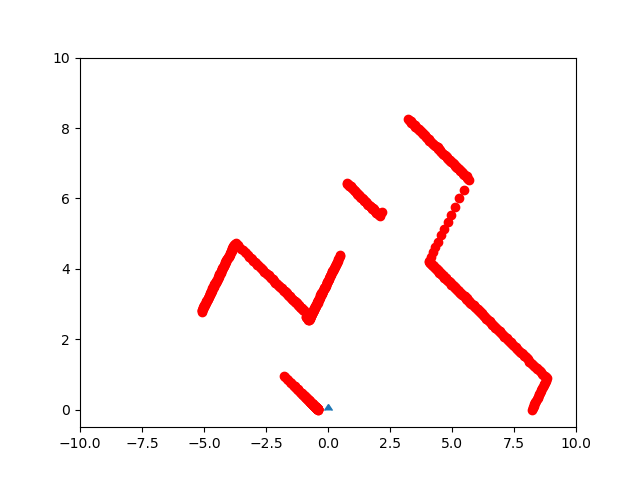

In [11]:
# @hidden
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('.cm-comment:contains(@hidden)').closest('div.input').hide();
 } else {
 $('.cm-comment:contains(@hidden)').closest('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

class VisualiserLaser:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'ro')
        self.x_data, self.y_data = [], []

    def plot_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-0.5, 10)
        self.ax.plot([0], marker=10)
        return self.ln

    def laser_callback(self, msg):
        angle = 0
        self.x_data, self.y_data = [], []
        for i in range(len(msg.ranges)):
            self.y_data.append(msg.ranges[i] * math.sin(angle))
            self.x_data.append(msg.ranges[i] * math.cos(angle))
#             self.y_data.append(msg.ranges[i])
#             self.x_data.append(theta)
            angle = angle + msg.angle_increment

    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)

        return self.ln


vis = VisualiserLaser()
sub_laser_ = rospy.Subscriber('/scan', LaserScan, vis.laser_callback)
ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init)
plt.show(block=False)

<IPython.core.display.Javascript object>


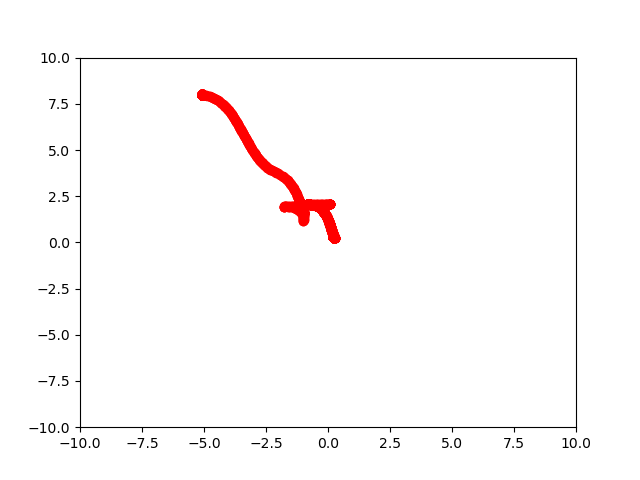

In [12]:
# @hidden
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('.cm-comment:contains(@hidden)').closest('div.input').hide();
 } else {
 $('.cm-comment:contains(@hidden)').closest('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

class Visualiser:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [], 'ro')
        self.x_data, self.y_data = [], []
        self.update = 0

    def plot_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        return self.ln

    def odom_callback(self, msg):
        if self.update > 100:
            self.y_data.append(msg.pose.pose.position.y)
            self.x_data.append(msg.pose.pose.position.x)
            self.update = 0
        else:
            self.update = self.update + 1

    def update_plot(self, frame):
        self.ln.set_data(self.x_data, self.y_data)
        return self.ln


visPos = Visualiser()
sub = rospy.Subscriber('/odom', Odometry, visPos.odom_callback)
aniPos = FuncAnimation(visPos.fig, visPos.update_plot,
                       init_func=visPos.plot_init, interval=1000)
plt.show(block=False)

<IPython.core.display.Javascript object>


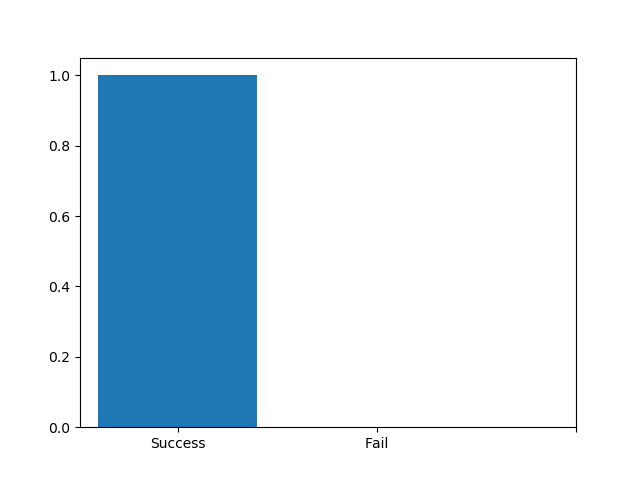

In [14]:
# @hidden
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('.cm-comment:contains(@hidden)').closest('div.input').hide();
 } else {
 $('.cm-comment:contains(@hidden)').closest('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

class VisualiserGoal:
    def __init__(self):
        self.fig, self.ax = plt.subplots()
        self.ln, = plt.plot([], [])
        plt.xticks([1, 2, 3], ['Success','Fail']);

    def plot_init(self):
        self.ax.set_xlim(-10, 10)
        self.ax.set_ylim(-10, 10)
        return self.ln
    
    def update_plot(self, frame):
        plt.bar([1, 2], height=rospy.get_param("/reachedAndNot"))
        plt.xticks([1, 2, 3], ['Success','Fail']);
        return self.ln


visGoal = VisualiserGoal()
aniGoal = FuncAnimation(visGoal.fig, visGoal.update_plot, interval=3000)
plt.show(block=False)